# Figure S1: 6 panel plot
This notebook produces figure S1 of Tankersley et al. 2022. It is a 6 panel figure, showing various gridded dataset for the Ross Ice Shelf area. These include a) free-air gravity, b) magnetics, c) our sediment thickness, d) previous estimates of sediment thickness, e) bathymetry, and f) differece between the two sediment thickness models

In [2]:
# import necessary python packages
import pygmt
import geopandas as gpd
import os

In [3]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment\\Figures'

## Prep data

### Shaded basement regions

In [51]:
pygmt.grdfilter(grid='../data/results/Ross_Embayment_basement_filt.nc', 
                filter='g120000', nans='r', distance='0', 
                outgrid='../data/results/Ross_Embayment_basement_120k_filt.nc')

pygmt.grdclip(grid='../data/results/Ross_Embayment_basement_120k_filt.nc', 
              outgrid='../data/results/basement_highs.nc', 
              below='-1600/NaN')

pygmt.grdclip(grid='../data/results/Ross_Embayment_basement_120k_filt.nc', 
              outgrid='../data/results/basement_lows.nc', 
              above='-2600/NaN')

### Grids clipped to RIS

In [11]:
# use shapefile created with concave hull in QGIS to clip the grid back to data extent
!gmt grdmask ../data/input/RIS_outline.shp -G../data/tmp/RIS_mask.nc -R../data/results/Ross_Embayment_basement_filt.nc -NNaN/1/1

# basement
!gmt grdmath -Df ../data/results/Ross_Embayment_basement_filt.nc ../data/tmp/RIS_mask.nc MUL = ../data/results/RIS_basement_filt.nc

# sediment
!gmt grdmath -Df ../data/results/Ross_Embayment_sediment.nc ../data/tmp/RIS_mask.nc MUL = ../data/results/RIS_sediment.nc

# lindeque sediment
!gmt grdmath -Df ../data/tmp/Lindeque_sedthick_total.nc ../data/tmp/RIS_mask.nc MUL = ../data/results/RIS_lindeque_sediment.nc

### Sediment thickness difference

In [12]:
# subtract Lindeque sediment thickness from ours
!gmt grdmath -Df ../data/results/RIS_sediment.nc ../data/results/RIS_lindeque_sediment.nc  SUB = ../data/results/RIS_sediment_difference.nc

## Figure parameters

In [14]:
# set our PyGMT figure parameters, 
# we will use an Antarctic Polar Stereographic projection (EPSG3031)
# set the region of our figure, in meters from the South Pole
e_lim= -660_000
n_lim= -1_500_000
w_lim= 450_000
s_lim= -400_000

fig_height=180 # in mm

# calculate figure width and map scale
fig_width=fig_height*(w_lim-e_lim)/(s_lim-n_lim)
fig_ratio = (s_lim - n_lim) / (fig_height/1000)

# Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
fig_reg = str(e_lim) + '/' + str(w_lim) + '/' + str(n_lim) + '/' + str(s_lim)
fig_proj = "x1:" + str(fig_ratio)
fig_proj_ll = "s0/-90/-71/1:" + str(fig_ratio)

bar_width = fig_width/10 * 0.4 # colorbar 40% of figure width
pos_str = 'jBL+w' + str(bar_width) + 'c/.5c+jTL+o.8c/-2.4c+h'

## Figure functions

### general features

In [18]:
# since were duplicating lots of section of these 6 plots, we'll put 
#some of it in a function we can call each time
def add_map_features(label):    
    # plot graticules overtop, at 4d latitude and 30d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                      MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black,-=2p,white', 
                      MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                      MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                      MAP_POLAR_CAP = '90/90', ):
        fig.basemap(projection = fig_proj_ll, region = fig_reg,
                    frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
        with pygmt.config(FONT_ANNOT_PRIMARY = '8p,black'):
            fig.basemap(projection = fig_proj_ll, region = fig_reg,
                    frame = ["NSWE", "xa30", "ya4"], verbose='e') 

    # plot groundingline and coastlines
    fig.plot(data=gpd.read_file('../data/input/GroundingLine_Antarctica_v02.shp'), 
             pen = '1.2p,black', verbose='e')
    fig.plot(data=gpd.read_file('../data/input/Coastline_Antarctica_v02.shp'), 
             pen='1.2p,black', verbose='e')

    # scalebar
    with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '16p,black', MAP_SCALE_HEIGHT='8p', MAP_TICK_PEN_PRIMARY = '0.5p,black'):
        fig.basemap(region = fig_reg, projection = fig_proj_ll, map_scale='jBR+w200k+c170E/71S+f+l"km"+ar+o1.7c/0.6c', verbose='e') 
        
    fig.text(projection = fig_proj, 
        region = fig_reg,
        position='TL',
        text = label,
        fill = 'white',
        font = '40p,Helvetica,black',
        offset = 'j.5/.5',
        clearance = '+tO')

### faults

In [16]:
# same with a func for plotting faults
def plot_faults(active_color='black', inactive_color='white'):
    pen_fault='1.8p,'+str(inactive_color)+',10_2'#10:2 dash:gap
    hatch_style='f+.4c/.3c+l+i'
    # Plot christines inactive faults, with hatches
    fig.plot(projection = fig_proj, data =gpd.read_file('../data/input/RIS_inactive_faults_normal.shp'), pen=pen_fault)
    fig.plot(data =gpd.read_file('../data/input/RIS_inactive_faults_normal.shp'), pen='1.2p,'+str(inactive_color)+',10_2', style=hatch_style) #f for front, +.6c/0.3c for a tick every .6c, .3c long, +l for left side.
    # Left lateral, with arrows
    fig.plot(data =gpd.read_file('../data/input/RIS_inactive_faults_left_lateral.shp'), pen=pen_fault)
    fig.plot(data =gpd.read_file('../data/input/RIS_inactive_faults_left_lateral.shp'), pen='1.5p,'+str(inactive_color), style='f-1c/.6c+l+s45+i') #f for front, -1 for 1 arrow, .8c for size of arrow, +l for left side, +s45 for arrow angle, +i for invisible line
    # no kinematics
    fig.plot(data =gpd.read_file('../data/input/RIS_inactive_faults.shp'), pen=pen_fault)
    # Plot christines active faults, with hatches
    fig.plot(data =gpd.read_file('../data/input/RIS_active_faults.shp'), pen='1.8p,'+str(active_color)+',10_2')
    fig.plot(data =gpd.read_file('../data/input/RIS_active_faults.shp'), pen='1.2p,'+str(active_color)+',10_2', style=hatch_style) # f for front, +.3c/.3c for tick every .3c, .3c long, , +l for left side, +i for invisible

## Make figure

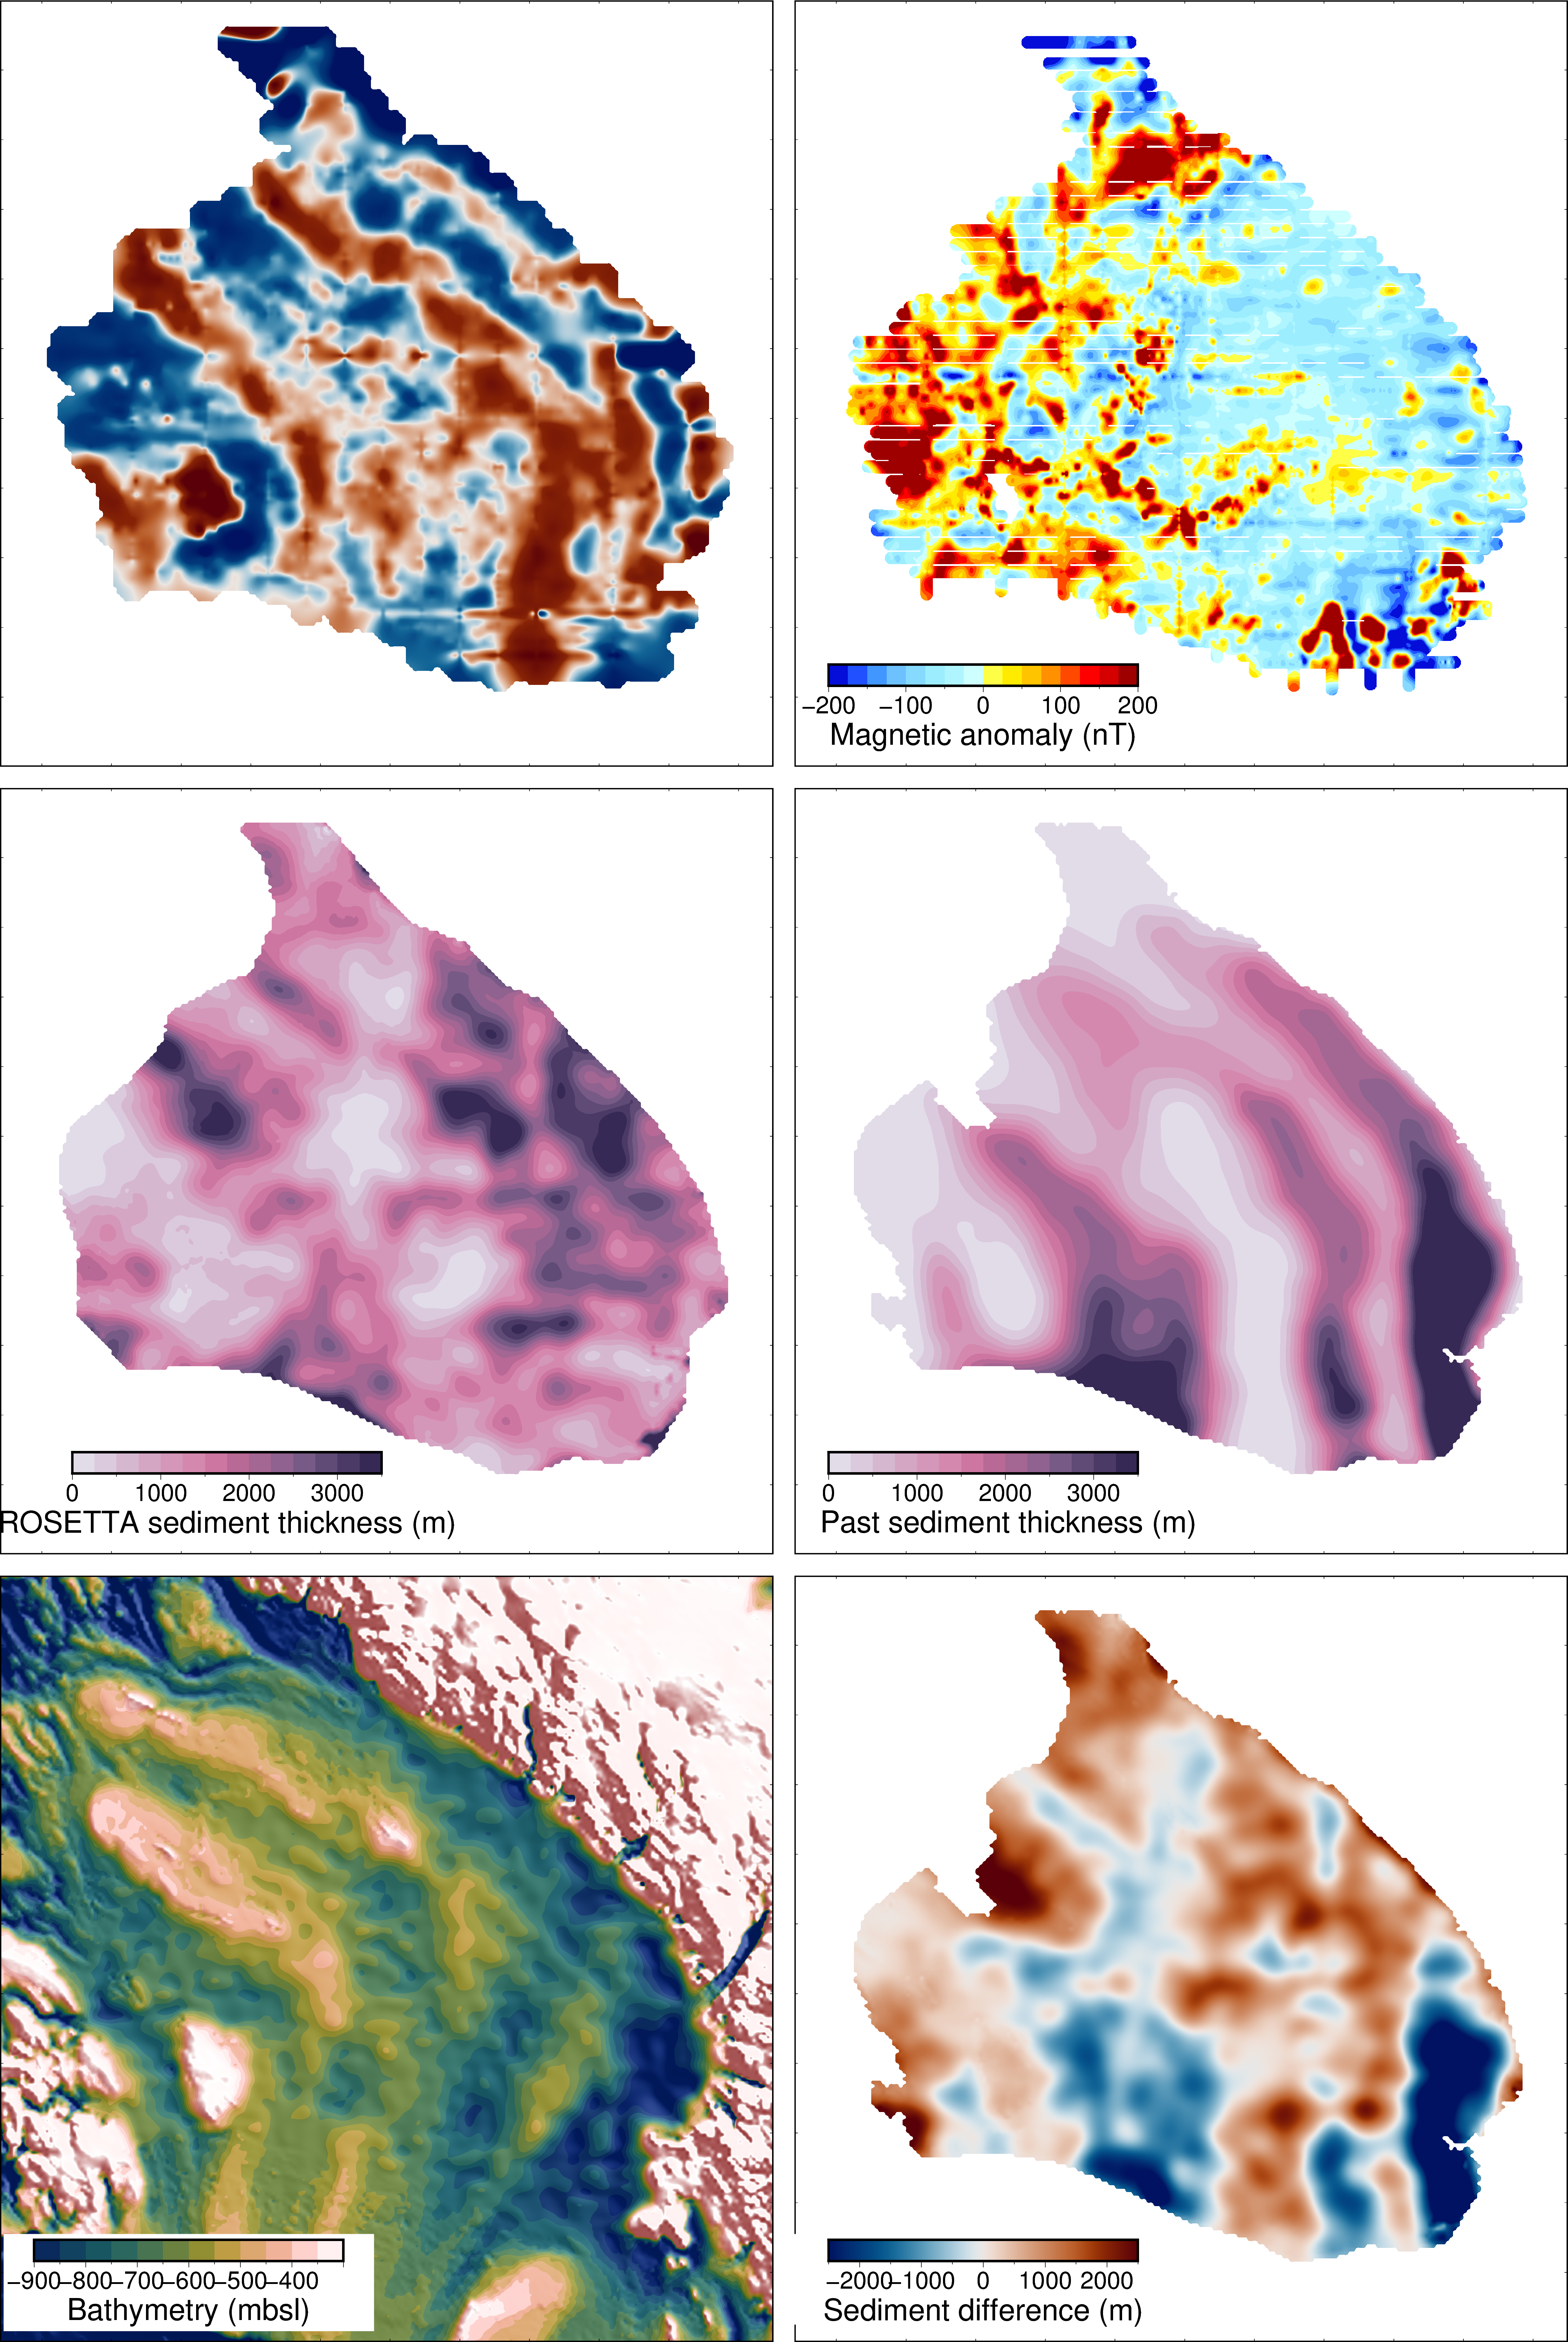

In [24]:
# initialize the figure
fig = pygmt.Figure()

############################
############################
# 5th FIGURE Bathy
############################
############################

grid='.../data/results/BedMachine_bed_wgs.nc'
cmap= '../data/results/RE_bathymetry.cpt'
frame=['xa100f50+l"Bathymetry (mbsl)"']

pygmt.grd2cpt(grid=grid, cmap='batlowW', limit='-900/-300', nlevels=13, output=cmap)        

with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"], 
                 grid=grid, cmap=cmap, shading="grdgradient+a45+ne.5", nan_transparent=True, dpi=500)

# fig.grdcontour(grid=grid, interval=500, pen='thinner,gray')

with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '20p,black'):
        fig.colorbar(cmap=cmap, position = pos_str,  box = '+gwhite+c3p', frame=frame, verbose='e')

# plot_faults()       

add_map_features(label='e')

############################
############################
fig.shift_origin(xshift=(fig_width/10)+.5, yshift=0)
# 6th FIGURE Sed Thick Diff
############################
############################

grid='../data/results/RIS_sediment_difference.nc'
cmap='../data/results/sed_thickness_diff.cpt'
frame=['xa1000f500+l"Sediment difference (m)"']

pygmt.makecpt(cmap='vik', background='o', series='-2500/2500', output=cmap)

with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"], 
                 grid=grid, cmap=cmap, nan_transparent=True, dpi=500)

# fig.grdcontour(grid=grid, interval=1000, pen='thinner,dimgray')#, cut = "300000c")

# hist_reg = '-2500/2500/0/7',   # this needs to match CMAP limits, 0/14 of 0-14% for histogram
# sed_diff=pygmt.grd2xyz(grid=grid)
# fig.shift_origin(xshift='.8c', yshift="2.4c",)
# fig.histogram( data=sed_diff.z,
#                 region=hist_reg,
#                 fill='grey',
#                 projection="X"+str(bar_width)+"c/1c",
#                 frame=False,
#                 series=100,#width of bin in data units
#                 pen=".1p",
#                 histtype=1) 
# fig.plot(x=[sed_diff.z.mean(),sed_diff.z.mean()], y=[0,7], pen='2p,black')
# fig.shift_origin(xshift='-.8c', yshift="-2.4c",)

with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap=cmap, position = pos_str, box = '+gwhite+c3p', frame=frame, verbose='e')

add_map_features(label='f')

############################
###########################
fig.shift_origin(xshift=0, yshift=(fig_height/10)+.5)
# 4th FIGURE Lindeque Sed Thick  
############################
############################

grid='../data/results/RIS_lindeque_sediment.nc'
cmap='../data/results/sediment.cpt'
frame=['xa1000f500+l"      Past sediment thickness (m)"']

with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"], 
                 grid=grid, cmap=cmap, nan_transparent=True, dpi=500)

# fig.grdcontour(grid=grid, interval=1000, pen='thinner,gray,')

with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '20p,black'):
        fig.colorbar(cmap=cmap, position = pos_str,  box = '+gwhite+c3p', frame=frame, verbose='e')

add_map_features(label='d')

############################
###########################
fig.shift_origin(xshift=(-fig_width/10)-.5, yshift=0)
# 3rd FIGURE ROSETTA Sed Thick  
############################
############################

grid='../data/results/RIS_sediment.nc'
cmap='../data/results/sediment.cpt'
frame=['xa1000f500+l"ROSETTA sediment thickness (m)"']

pos_str2 = 'jBL+w' + str(bar_width) + 'c/.5c+jTL+o1.7c/-2.4c+h' 

with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"], 
                 grid=grid, cmap=cmap, nan_transparent=True, dpi=500)

# fig.grdcontour(grid=grid, interval=1000, pen='thinner,gray,')

with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '20p,black'):
        fig.colorbar(cmap=cmap, position = pos_str2,  box = '+gwhite+c3p', frame=frame, verbose='e')

# plot_faults()
    
add_map_features(label='c')

############################
###########################
fig.shift_origin(xshift=(fig_width/10)+.5, yshift=(fig_height/10)+.5)
# 2nd FIGURE Mag 
############################
############################

grid='../data/results/rosetta_mag.nc'
cmap='../data/results/RIS_mag_full.cpt'
frame=['xa100f50+l"Magnetic anomaly (nT)"']

pygmt.makecpt(series='-200/200', cmap='panoply', background='o', output=cmap)

with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"], 
                 grid=grid, cmap=cmap, nan_transparent=True, dpi=500)

with pygmt.config(FONT_ANNOT_PRIMARY = '16p,black', FONT_LABEL = '20p,black'):
        fig.colorbar(cmap=cmap, position = pos_str,  box = '+gwhite+c3p', frame=frame, verbose='e')
        
# plot_faults(active_color='black', inactive_color='gray50')
    
add_map_features(label='b')

############################
############################
fig.shift_origin(xshift=(-fig_width/10)-.5, yshift=0)
# 1st FIGURE Grav
############################
############################

grid='../data/results/rosetta_grav.nc'
cmap='../data/tmp/rosetta_grav.cpt'
frame=['xa20f10+l"Free air gravity (mGal)"']

pygmt.grd2cpt(grid=grid, cmap='vik', limit='-80/0', continuous=True, output=cmap)


with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = fig_reg, projection = fig_proj, frame=["nwse", "xf100000", "yf100000", "g0"], 
                 grid=grid, cmap=cmap, nan_transparent=True, dpi=500)
    
# plot_faults()
  
# pygmt.makecpt(cmap = 'goldenrod', series='-1700/0', output = '../data/tmp/basement_highs.cpt')
# fig.grdimage(grid='../data/results/basement_highs.nc', cmap='../data/tmp/basement_highs.cpt', nan_transparent=True,dpi='600', transparency=60)

# pygmt.makecpt(cmap = 'navy', series='-5000/-2500', output = '../data/tmp/basement_lows.cpt')
# fig.grdimage(grid='../data/results/basement_lows.nc', cmap='../data/tmp/basement_lows.cpt', nan_transparent=True,dpi='600', transparency=60)

# fig.grdcontour(grid='../data/results/Ross_Embayment_basement_120k_filt.nc', interval=1600, limit='-1601/-1599', pen='thicker,black',)
# fig.grdcontour(grid='../data/results/Ross_Embayment_basement_120k_filt.nc', interval=2600, limit='-2601/-2599', pen='thicker,black',)

add_map_features(label='a')

fig.show()

## Save figure

In [55]:
out='outputs/FigS1_six_panel.jpg'
fig.savefig(out, dpi=200)

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.
